In [1]:
cd ..

c:\Users\shish\Purdue\First Sem\Independent Study\Final_Proj_SM\Github_Proj\SoMoBoost


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import shap
import rasterio
from rasterio.plot import show

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


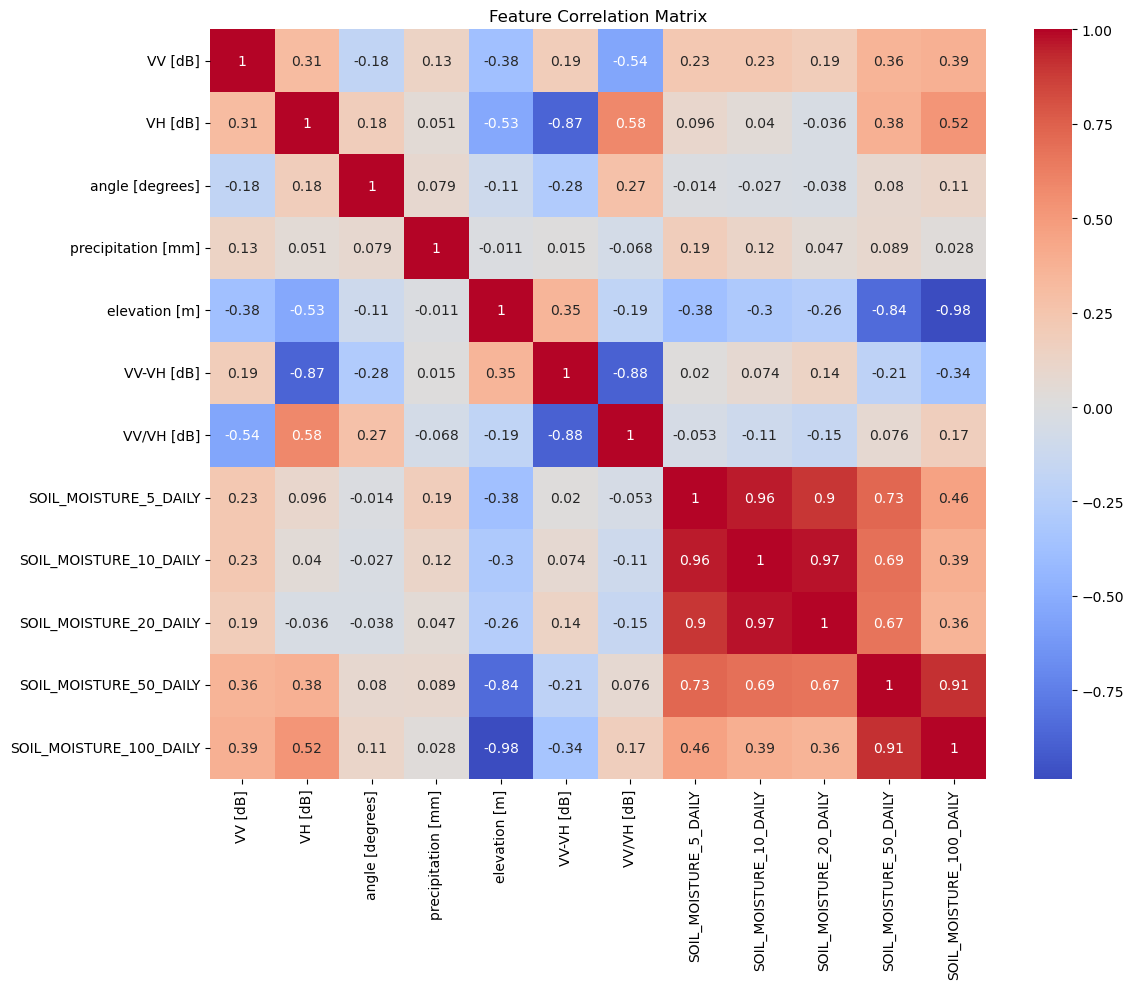

In [3]:
# Load and preprocess data
df = pd.read_csv("Datasets/ML_Training_Selected.csv")

# Correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")

# Save the figure before showing
plt.tight_layout()
plt.savefig("Results/correlation_matrix.png", dpi=300)
plt.show()


In [4]:
# Calculate SOIL_MOISTURE_15_DAILY and SOIL_MOISTURE_75_DAILY
#df['SOIL_MOISTURE_15_DAILY'] = (df['SOIL_MOISTURE_10_DAILY'] + df['SOIL_MOISTURE_20_DAILY']) / 2
#df['SOIL_MOISTURE_75_DAILY'] = (df['SOIL_MOISTURE_50_DAILY'] + df['SOIL_MOISTURE_100_DAILY']) / 2

# Drop unnecessary columns
#df.drop(columns=['SOIL_MOISTURE_10_DAILY', 'SOIL_MOISTURE_20_DAILY', 'SOIL_MOISTURE_50_DAILY', 'SOIL_MOISTURE_100_DAILY'], inplace=True)

# Clean column names
df.columns = df.columns.str.replace('[\[\]<>]', '', regex=True).str.replace(' ', '_')

# Define features
features = ['VV_dB', 'VH_dB', 'angle_degrees', 'precipitation_mm', 'elevation_m', 'VV-VH_dB', 'VV/VH_dB']

# Normalize elevation
scaler = StandardScaler()
df['elevation_m'] = scaler.fit_transform(df[['elevation_m']])

# Target variables
targets = {
    'SOIL_MOISTURE_5_DAILY': None,
    'SOIL_MOISTURE_10_DAILY': None,
    'SOIL_MOISTURE_20_DAILY': None,
    'SOIL_MOISTURE_50_DAILY': None,
    'SOIL_MOISTURE_100_DAILY': None,
}

100%|██████████| 100/100 [00:26<00:00,  3.72trial/s, best loss: 0.07512127138529193]
--- SOIL_MOISTURE_5_DAILY ---
Train R^2: 0.456, KGE: 0.415, NSE: 0.456
Test R^2: 0.012, KGE: 0.138, NSE: 0.012


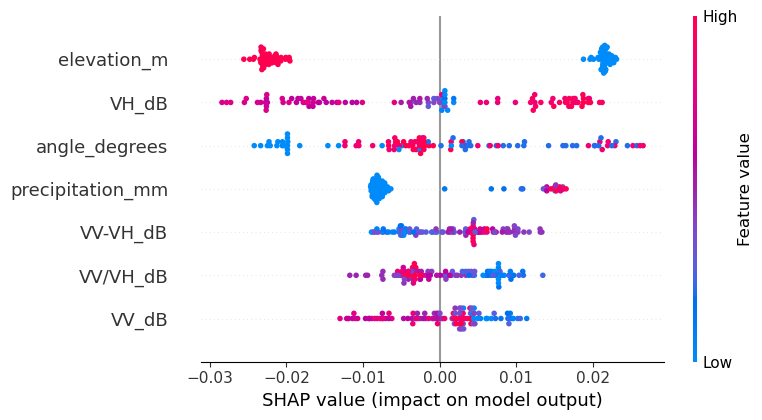

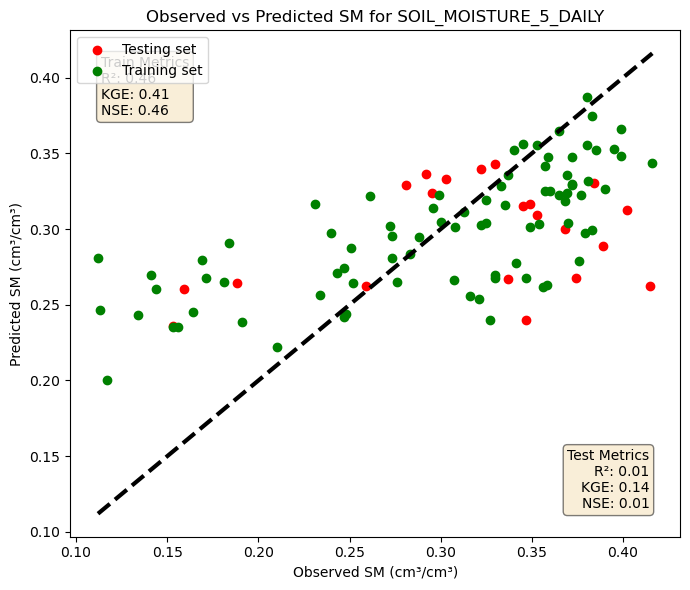

100%|██████████| 100/100 [00:27<00:00,  3.66trial/s, best loss: 0.06809561951813389]
--- SOIL_MOISTURE_10_DAILY ---
Train R^2: 0.540, KGE: 0.460, NSE: 0.540
Test R^2: -0.049, KGE: 0.129, NSE: -0.049


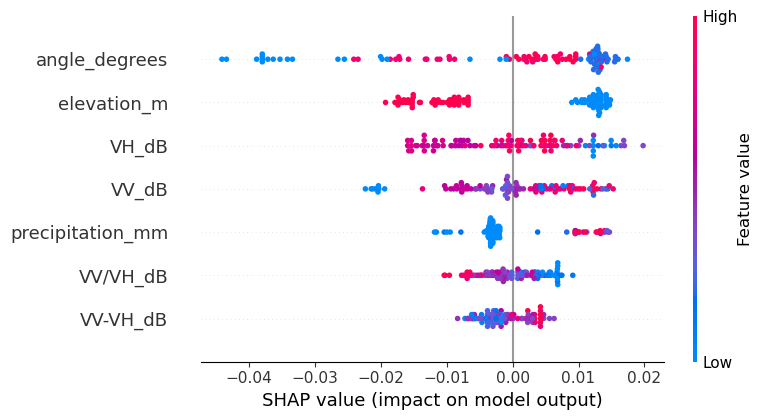

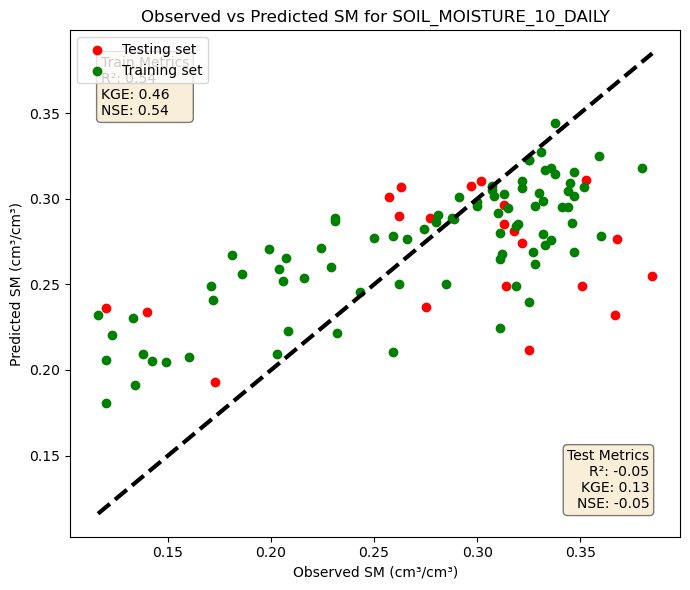

100%|██████████| 100/100 [00:27<00:00,  3.61trial/s, best loss: 0.05433595093949799]
--- SOIL_MOISTURE_20_DAILY ---
Train R^2: 0.361, KGE: 0.260, NSE: 0.361
Test R^2: -0.076, KGE: -0.078, NSE: -0.076


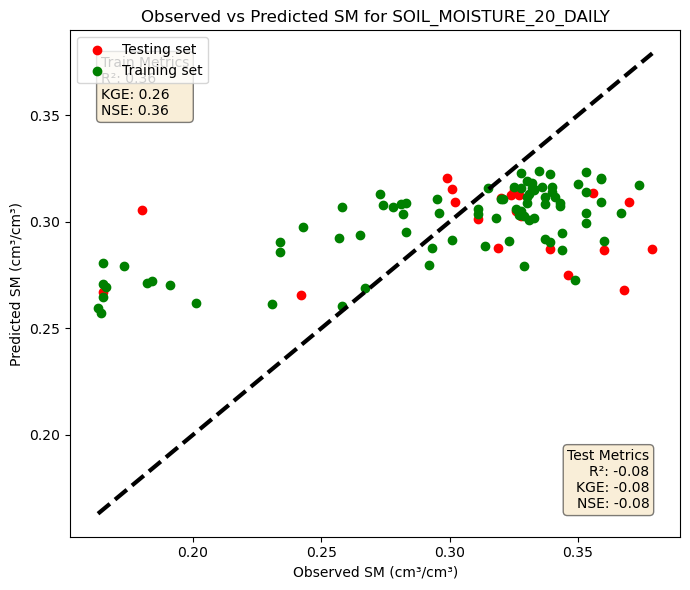

100%|██████████| 100/100 [00:30<00:00,  3.33trial/s, best loss: 0.04704910242556242]
--- SOIL_MOISTURE_50_DAILY ---
Train R^2: 0.942, KGE: 0.906, NSE: 0.942
Test R^2: 0.585, KGE: 0.799, NSE: 0.585


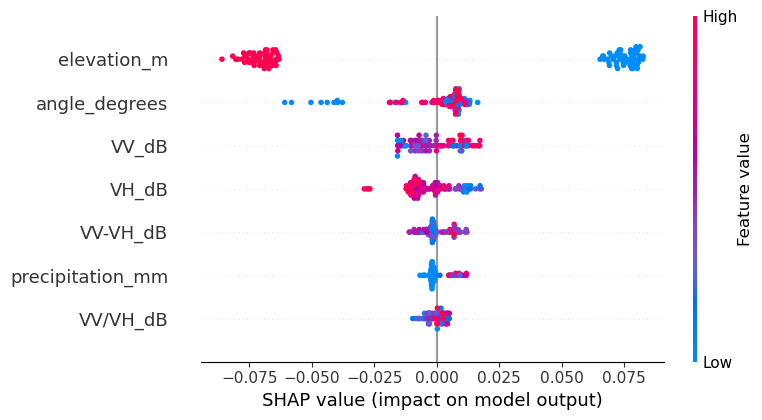

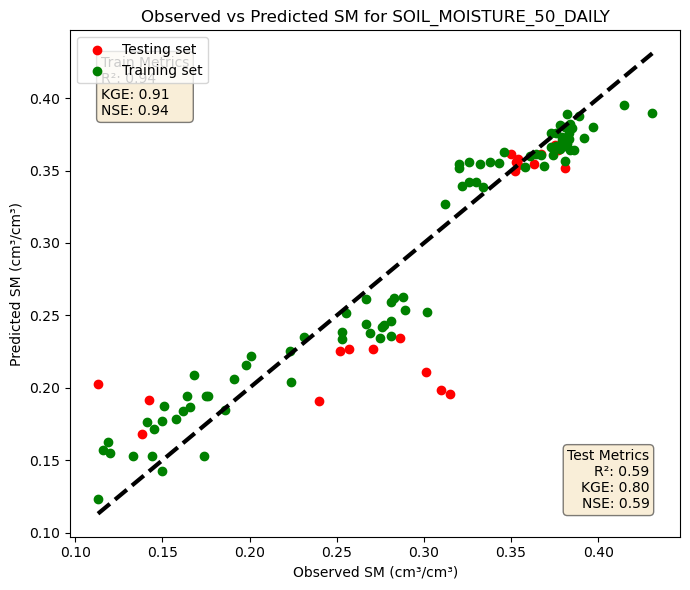

100%|██████████| 100/100 [00:28<00:00,  3.51trial/s, best loss: 0.026942703499911035]
--- SOIL_MOISTURE_100_DAILY ---
Train R^2: 0.989, KGE: 0.985, NSE: 0.989
Test R^2: 0.956, KGE: 0.941, NSE: 0.956


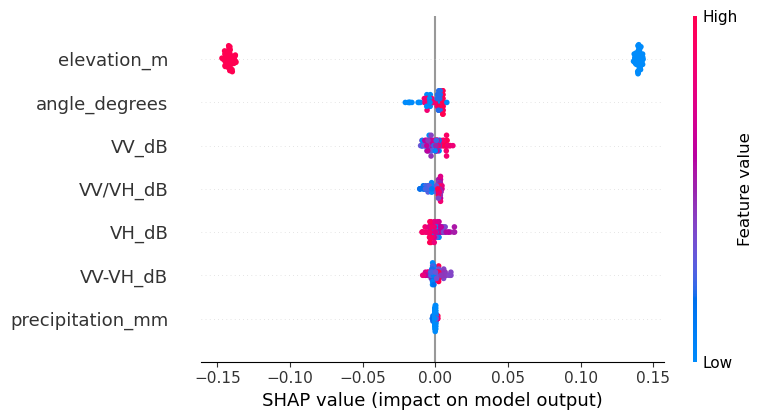

In [5]:
# Dictionary to store trained models
targets = {}

# Define hyperparameter space
space = {
    'n_estimators': hp.choice('n_estimators', range(50, 300)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 8)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(3, 6)),
    'max_depth': hp.choice('max_depth', range(2, 4)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'subsample': hp.uniform('subsample', 0.05, 0.5),
    'random_state': 42,
}

random_seed = 42
X = df[features]

# Define evaluation metrics
def kge(sim, obs):
    r = np.corrcoef(sim, obs)[0, 1]
    alpha = np.std(sim) / np.std(obs)
    beta = np.mean(sim) / np.mean(obs)
    return 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

def nse(sim, obs):
    return 1 - np.sum((sim - obs) ** 2) / np.sum((obs - np.mean(obs)) ** 2)

# Loop through each SM depth target
for target_col in ['SOIL_MOISTURE_5_DAILY', 'SOIL_MOISTURE_10_DAILY', 'SOIL_MOISTURE_20_DAILY', 'SOIL_MOISTURE_50_DAILY', 'SOIL_MOISTURE_100_DAILY']:
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

    # Objective function for optimization
    def objective(params):
        model = GradientBoostingRegressor(**params)
        kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)
        rmse_list = []
        for train_idx, test_idx in kf.split(X_train):
            model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
            preds = model.predict(X_train.iloc[test_idx])
            rmse = np.sqrt(mean_squared_error(y_train.iloc[test_idx], preds))
            rmse_list.append(rmse)
        return {'loss': np.mean(rmse_list), 'status': STATUS_OK}

    # Hyperparameter tuning
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials, rstate=np.random.default_rng(random_seed))

    # Retrieve best parameters
    best_params = {
        'n_estimators': range(50, 300)[best['n_estimators']],
        'min_samples_split': range(2, 8)[best['min_samples_split']],
        'min_samples_leaf': range(3, 6)[best['min_samples_leaf']],
        'max_depth': range(2, 4)[best['max_depth']],
        'learning_rate': best['learning_rate'],
        'subsample': best['subsample'],
        'random_state': 42
    }

    # Train final model
    final_model = GradientBoostingRegressor(**best_params)
    final_model.fit(X_train, y_train)
    y_pred_train = final_model.predict(X_train)
    y_pred_test = final_model.predict(X_test)

    # Print metrics
    print(f"--- {target_col} ---")
    print(f"Train R^2: {r2_score(y_train, y_pred_train):.3f}, KGE: {kge(y_pred_train, y_train):.3f}, NSE: {nse(y_pred_train, y_train):.3f}")
    print(f"Test R^2: {r2_score(y_test, y_pred_test):.3f}, KGE: {kge(y_pred_test, y_test):.3f}, NSE: {nse(y_pred_test, y_test):.3f}")

    # SHAP summary plot
    explainer = shap.Explainer(final_model)
    shap_values = explainer(X)
    shap.summary_plot(shap_values, X, feature_names=X.columns, show=False)
    plt.tight_layout()
    plt.savefig(f"Results/XGboost_SHAP_summary_{target_col}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Observed vs Predicted Scatter Plot
    fig, ax = plt.subplots(figsize=(7, 6))
    ax.scatter(y_test, y_pred_test, color='red', label='Testing set')
    ax.scatter(y_train, y_pred_train, color='green', label='Training set')
    ax.plot([min(y.min(), y_pred_test.min()), max(y.max(), y_pred_test.max())],
            [min(y.min(), y_pred_test.min()), max(y.max(), y_pred_test.max())],
            'k--', lw=3)

    # Metrics
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    kge_train = kge(y_pred_train, y_train)
    kge_test = kge(y_pred_test, y_test)
    nse_train = nse(y_pred_train, y_train)
    nse_test = nse(y_pred_test, y_test)

    # Annotate the plot
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95,
            f"Train Metrics\n"
            f"R²: {r2_train:.2f}\n"
            f"KGE: {kge_train:.2f}\n"
            f"NSE: {nse_train:.2f}",
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment='top',
            bbox=props)

    ax.text(0.95, 0.05,
            f"Test Metrics\n"
            f"R²: {r2_test:.2f}\n"
            f"KGE: {kge_test:.2f}\n"
            f"NSE: {nse_test:.2f}",
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment='bottom',
            ha='right',
            bbox=props)

    ax.set_xlabel('Observed SM (cm³/cm³)')
    ax.set_ylabel('Predicted SM (cm³/cm³)')
    ax.set_title(f"Observed vs Predicted SM for {target_col}")
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig(f"Results/XGboost_Observed_vs_Predicted_{target_col}.png", dpi=300)
    plt.show()

    # Store the trained model
    targets[target_col] = final_model

In [6]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Open the TIFF file
file_path = 'Datasets/FrankFort_Lexington_MultiBand_2024.tif'
with rasterio.open(file_path) as dataset:
    # Display the first band of the TIFF file
    plt.figure(figsize=(10, 10))
    show(dataset.read(1), title="Band 1")
    plt.show()
    
    # Print the band names
    band_names = [f"Band {i}" for i in range(1, dataset.count + 1)]
    print("Band names:", band_names)

Band names: ['Band 1', 'Band 2', 'Band 3', 'Band 4', 'Band 5']


In [7]:
import rasterio
import numpy as np
from rasterio.transform import from_origin

# Open the input TIFF file
with rasterio.open(file_path) as dataset:
    # Read all bands into a numpy array
    raster_data = dataset.read()

# Calculate VV-VH and VV/VH bands
vv_vh_band = raster_data[0] - raster_data[1]  # VV-VH
vv_div_vh_band = raster_data[0] / raster_data[1]  # VV/VH

# Stack the bands in the specified order
new_bands = [
    raster_data[0],  # VV [dB]
    raster_data[1],  # VH [dB]
    raster_data[2],  # angle [degrees]
    raster_data[3],  # precipitation [mm]
    raster_data[4],  # elevation [m]
    vv_vh_band,      # VV-VH [dB]
    vv_div_vh_band   # VV/VH [dB]
]
new_bands = np.stack(new_bands)

# Define metadata for the new TIFF
new_meta = dataset.meta.copy()
new_meta.update({
    "count": len(new_bands),  # Number of bands
    "dtype": new_bands.dtype  # Data type of the bands
})

# Write the new TIFF file
output_file = "Datasets/Updated_Frankfor_Lexington.tif"
with rasterio.open(output_file, "w", **new_meta) as dst:
    for i in range(len(new_bands)):
        dst.write(new_bands[i], i + 1)  # Write each band to the file

print(f"New TIFF file created: {output_file}")

New TIFF file created: Datasets/Updated_Frankfor_Lexington.tif


Saved: Results/XGboost_Predicted_Soil_Moisture_5 cm.tif
Saved: Results/XGboost_Predicted_Soil_Moisture_10 cm.tif
Saved: Results/XGboost_Predicted_Soil_Moisture_20 cm.tif


X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names


Saved: Results/XGboost_Predicted_Soil_Moisture_50 cm.tif
Saved: Results/XGboost_Predicted_Soil_Moisture_100 cm.tif


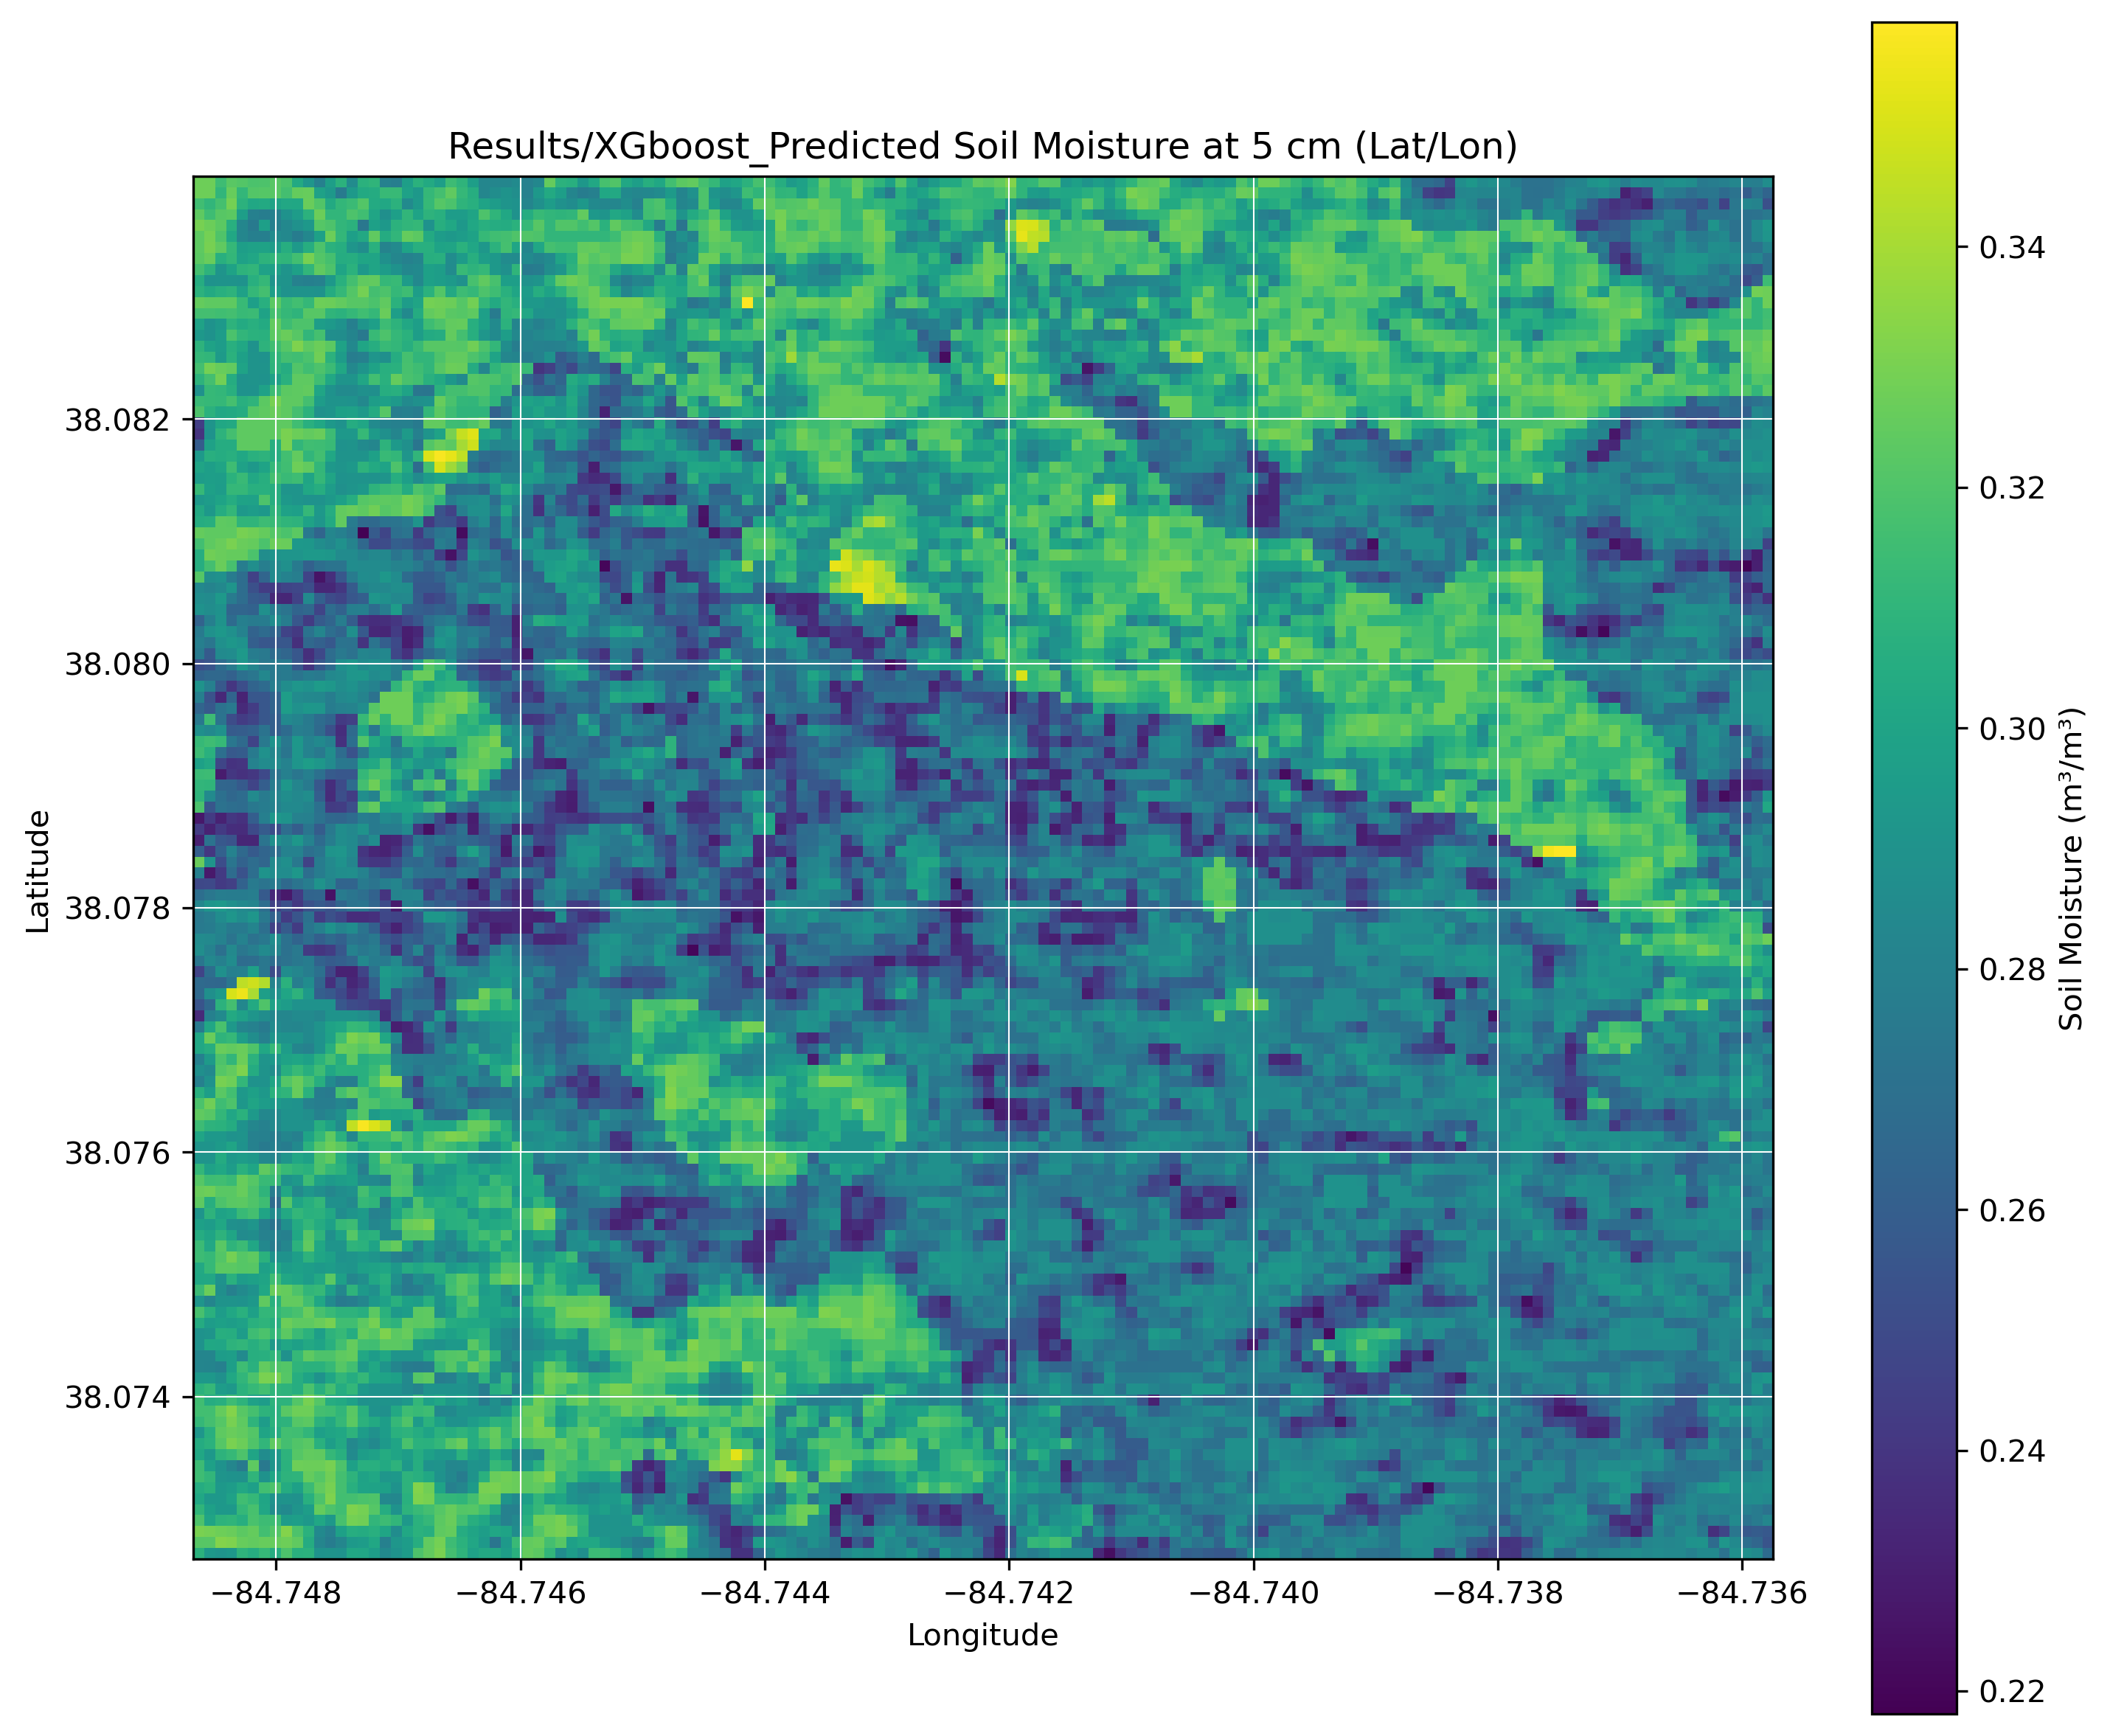

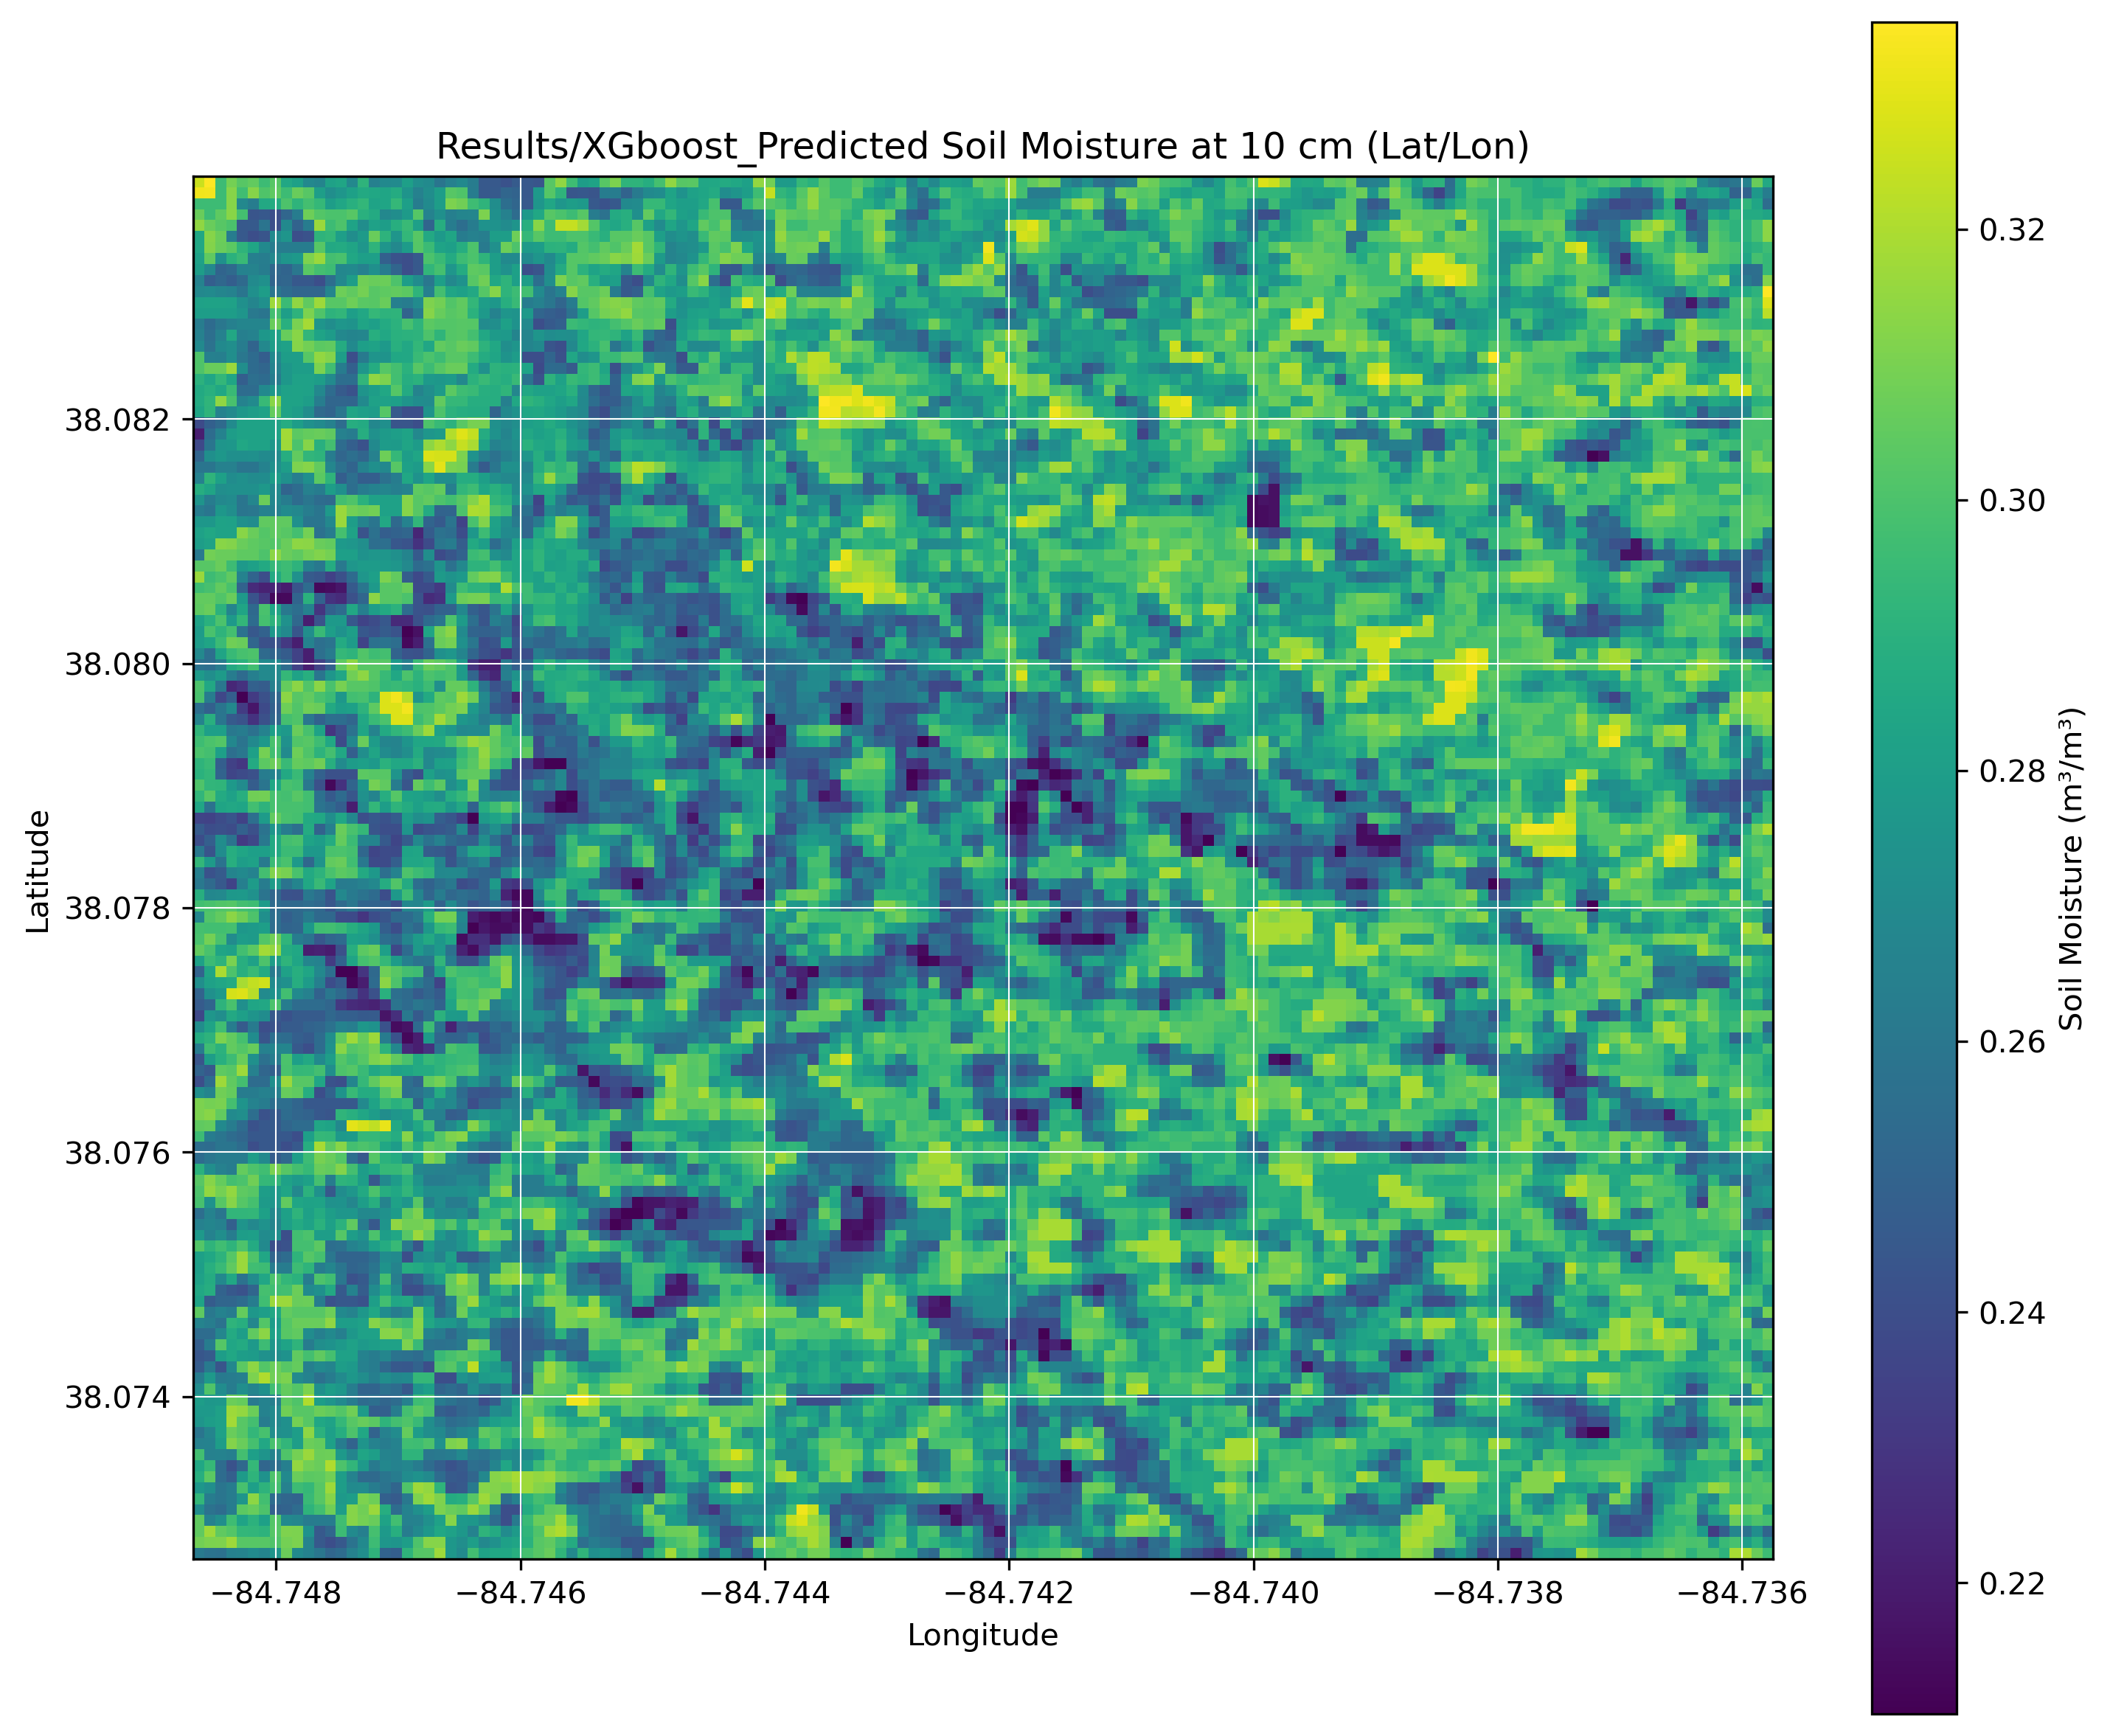

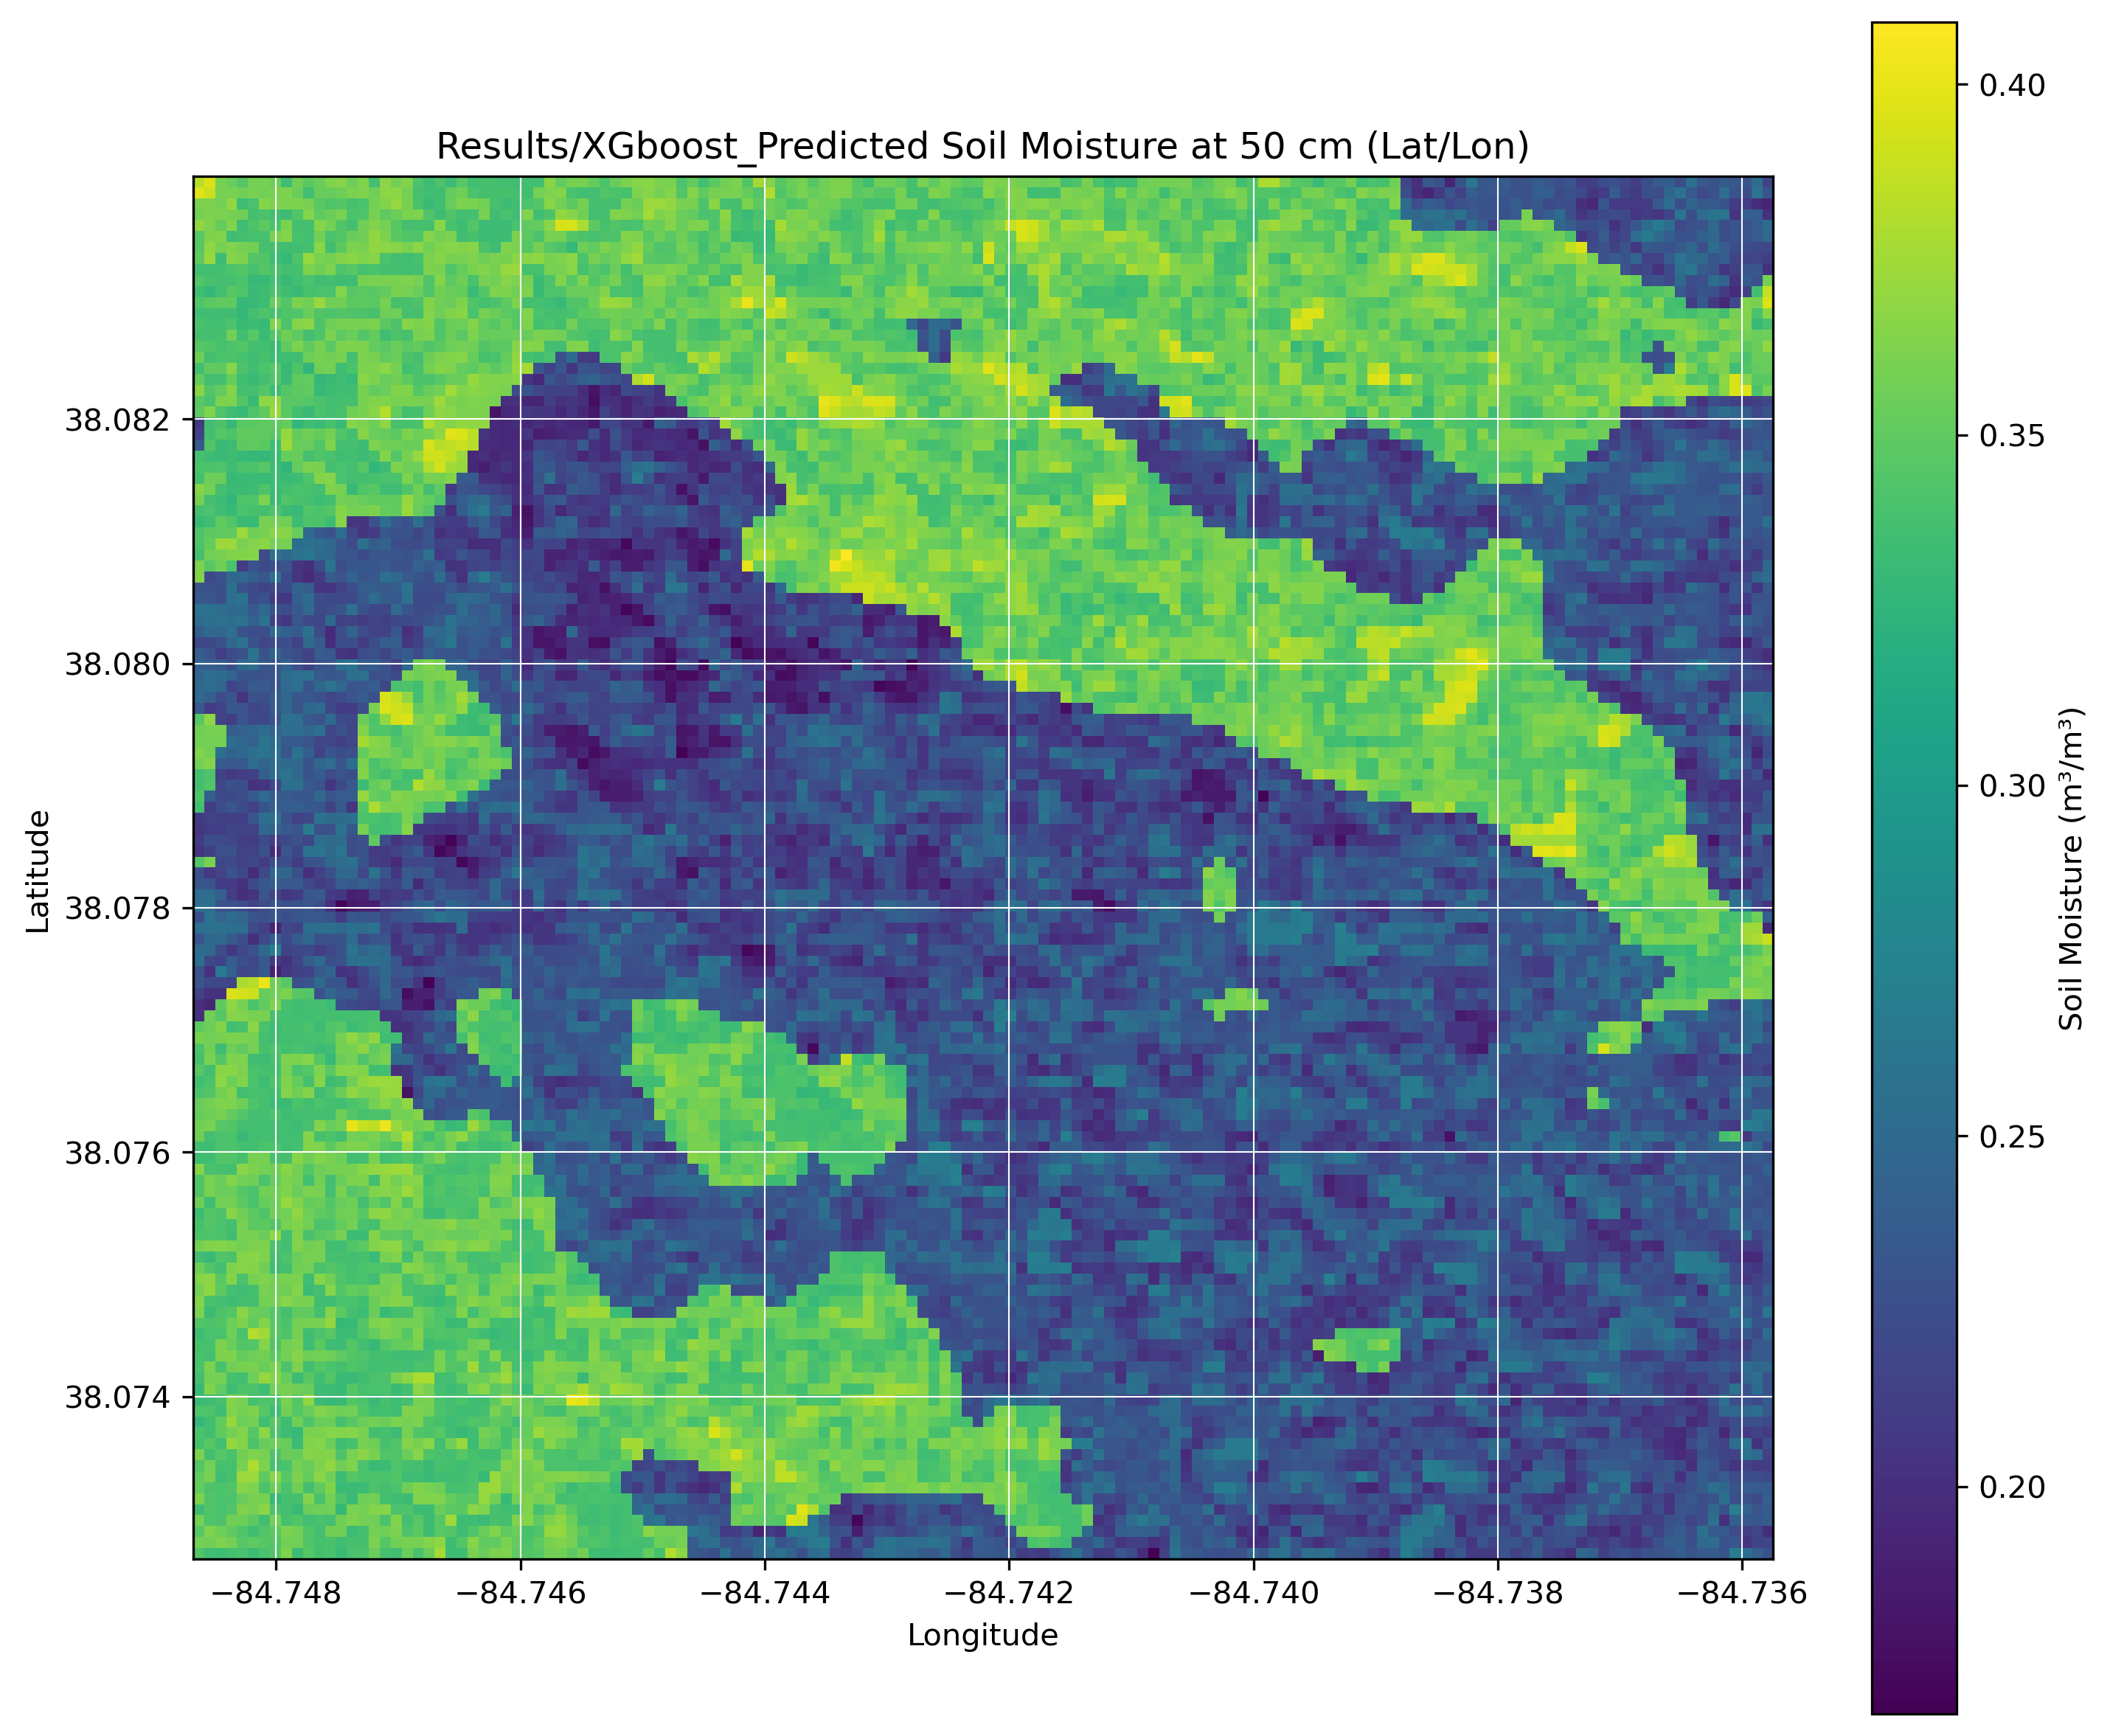

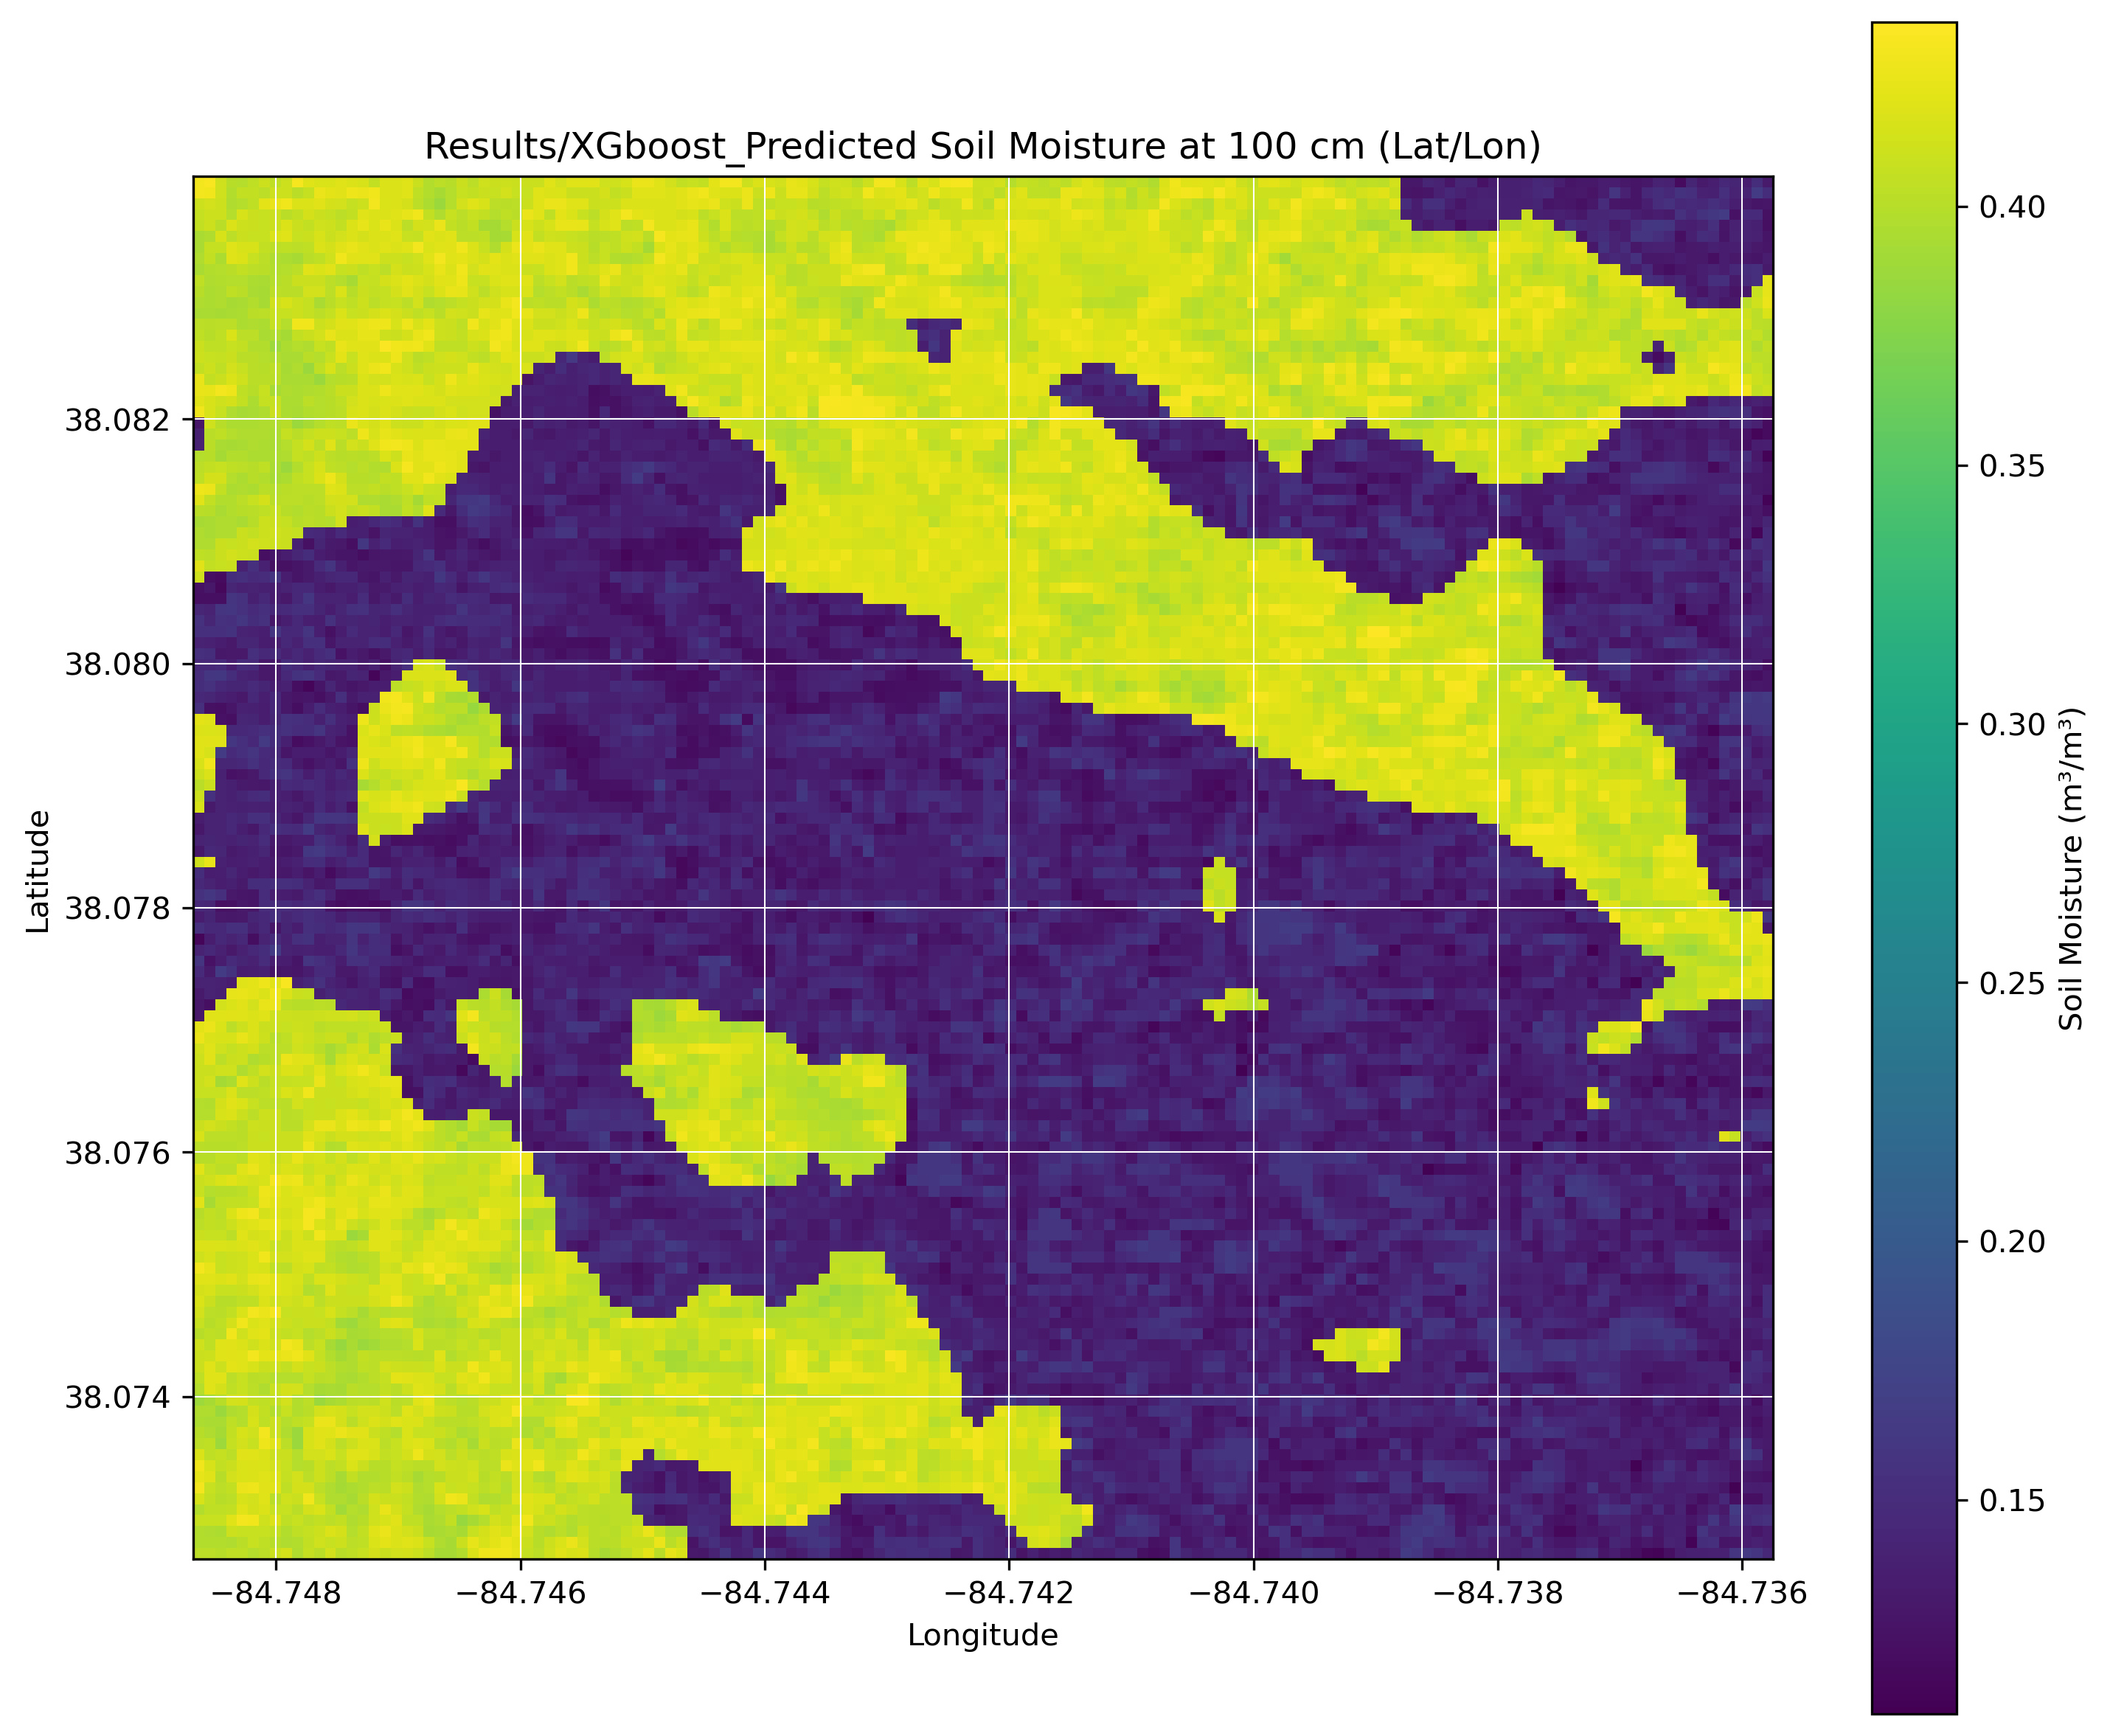

In [8]:
file_path = "Datasets/Updated_Frankfor_Lexington.tif"

with rasterio.open(file_path) as src:
    bands = src.read()  # shape: (bands, rows, cols)
    bands = np.transpose(bands, (1, 2, 0))  # shape: (rows, cols, bands)
    rows, cols, num_bands = bands.shape
    reshaped_data = bands.reshape(-1, num_bands)

    # 🟢 Calculate mean and std of 5th band (index 4)
    elevation_band = reshaped_data[:, 4]
    elevation_mean = elevation_band.mean()
    elevation_std = elevation_band.std()

    # 🟢 Scale 5th band
    reshaped_data[:, 4] = (elevation_band - elevation_mean) / elevation_std

    # Predict soil moisture
    predicted_sm = np.zeros((reshaped_data.shape[0], 5))
    depths = ['5 cm', '10 cm', '20 cm', '50 cm', '100 cm']
    for i, (target, model) in enumerate(targets.items()):
        predicted_sm[:, i] = model.predict(reshaped_data)

    predicted_sm = predicted_sm.reshape(rows, cols, 5)

    # Save each depth as GeoTIFF
    for i, depth in enumerate(depths):
        output_file = f"Results/XGboost_Predicted_Soil_Moisture_{depth}.tif"
        meta = src.meta.copy()
        meta.update({
            "count": 1,
            "dtype": predicted_sm.dtype
        })
        with rasterio.open(output_file, "w", **meta) as dst:
            dst.write(predicted_sm[:, :, i], 1)
        print(f"Saved: {output_file}")

def plot_geotiff_with_latlon(tif_path, title):
    with rasterio.open(tif_path) as src:
        image = src.read(1)
        transform = src.transform

        # Get bounds
        left, bottom, right, top = src.bounds

        # Create extent in lat/lon
        extent = (left, right, bottom, top)

        # Plot
        plt.figure(figsize=(10, 8), dpi=300)
        plt.imshow(image, cmap='viridis', extent=extent, origin='upper')
        plt.colorbar(label='Soil Moisture (m³/m³)')
        plt.title(title)
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.grid(True, which='both', color='white', linewidth=0.5)  # optional grid
        plt.tight_layout()
        plt.show()

# Example: Plot one of your saved TIFFs
for depth in depths:
    plot_geotiff_with_latlon(f"Results/XGboost_Predicted_Soil_Moisture_{depth}.tif",
                             f"Results/XGboost_Predicted Soil Moisture at {depth} (Lat/Lon)")

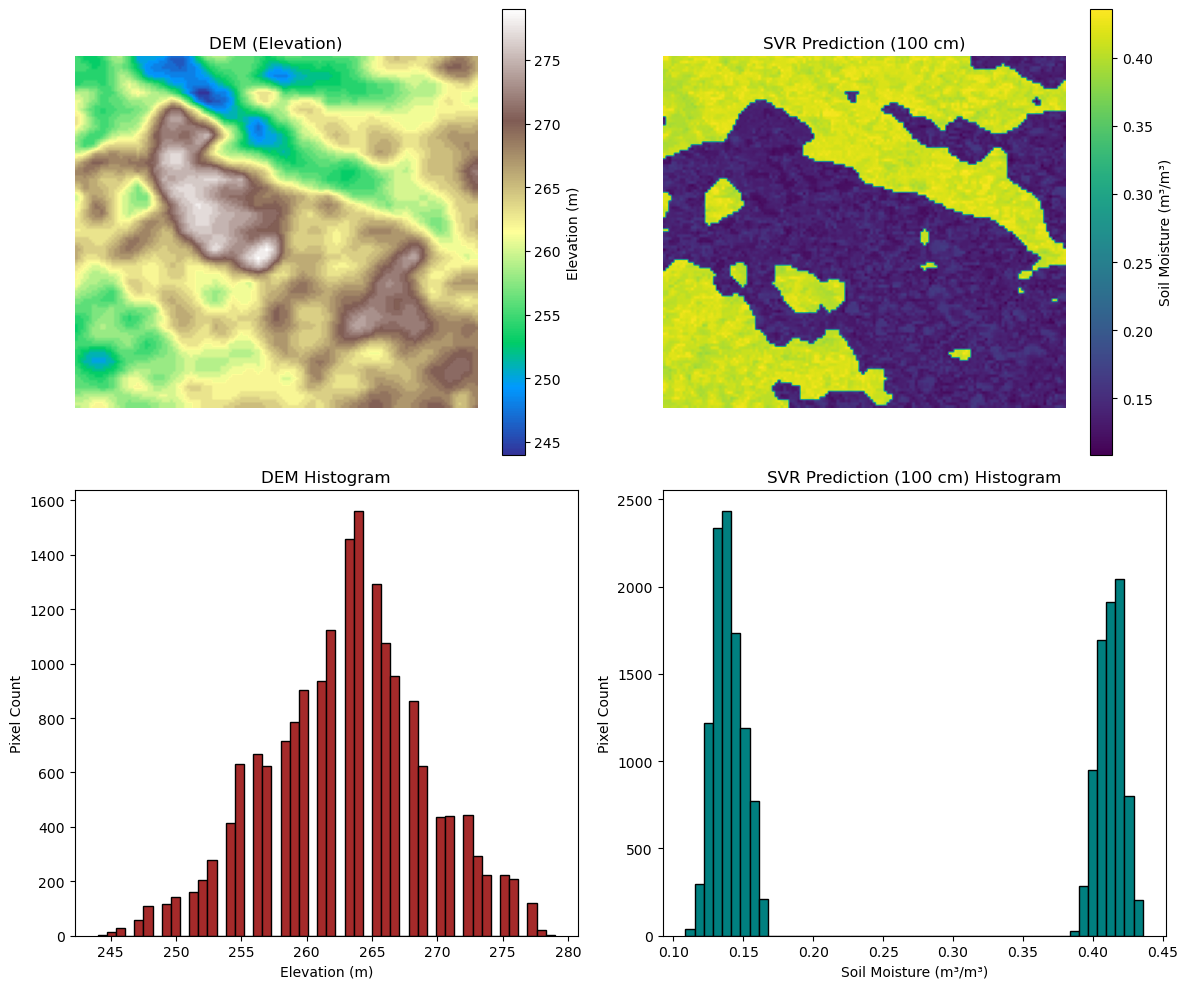

In [9]:
import rasterio

import matplotlib.pyplot as plt

# Open the TIFF file
with rasterio.open(file_path) as src:
    dem = src.read(5)  # 5th band for DEM
    svr_100cm = predicted_sm[:, :, 4]  # 100 cm prediction from SVR

# Create a 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Removed constrained_layout=True

# First row: Spatial plots
# DEM spatial plot
im1 = axes[0, 0].imshow(dem, cmap='terrain')
axes[0, 0].set_title("DEM (Elevation)")
axes[0, 0].axis('off')
fig.colorbar(im1, ax=axes[0, 0], orientation='vertical', label='Elevation (m)')

# SVR 100 cm spatial plot
im2 = axes[0, 1].imshow(svr_100cm, cmap='viridis')
axes[0, 1].set_title("SVR Prediction (100 cm)")
axes[0, 1].axis('off')
fig.colorbar(im2, ax=axes[0, 1], orientation='vertical', label='Soil Moisture (m³/m³)')

# Second row: Histograms
# DEM histogram
axes[1, 0].hist(dem.flatten(), bins=50, color='brown', edgecolor='black')
axes[1, 0].set_title("DEM Histogram")
axes[1, 0].set_xlabel("Elevation (m)")
axes[1, 0].set_ylabel("Pixel Count")

# SVR 100 cm histogram
axes[1, 1].hist(svr_100cm.flatten(), bins=50, color='teal', edgecolor='black')
axes[1, 1].set_title("SVR Prediction (100 cm) Histogram")
axes[1, 1].set_xlabel("Soil Moisture (m³/m³)")
axes[1, 1].set_ylabel("Pixel Count")

# Adjust layout
fig.tight_layout()  # Use tight_layout instead of constrained_layout
plt.show()

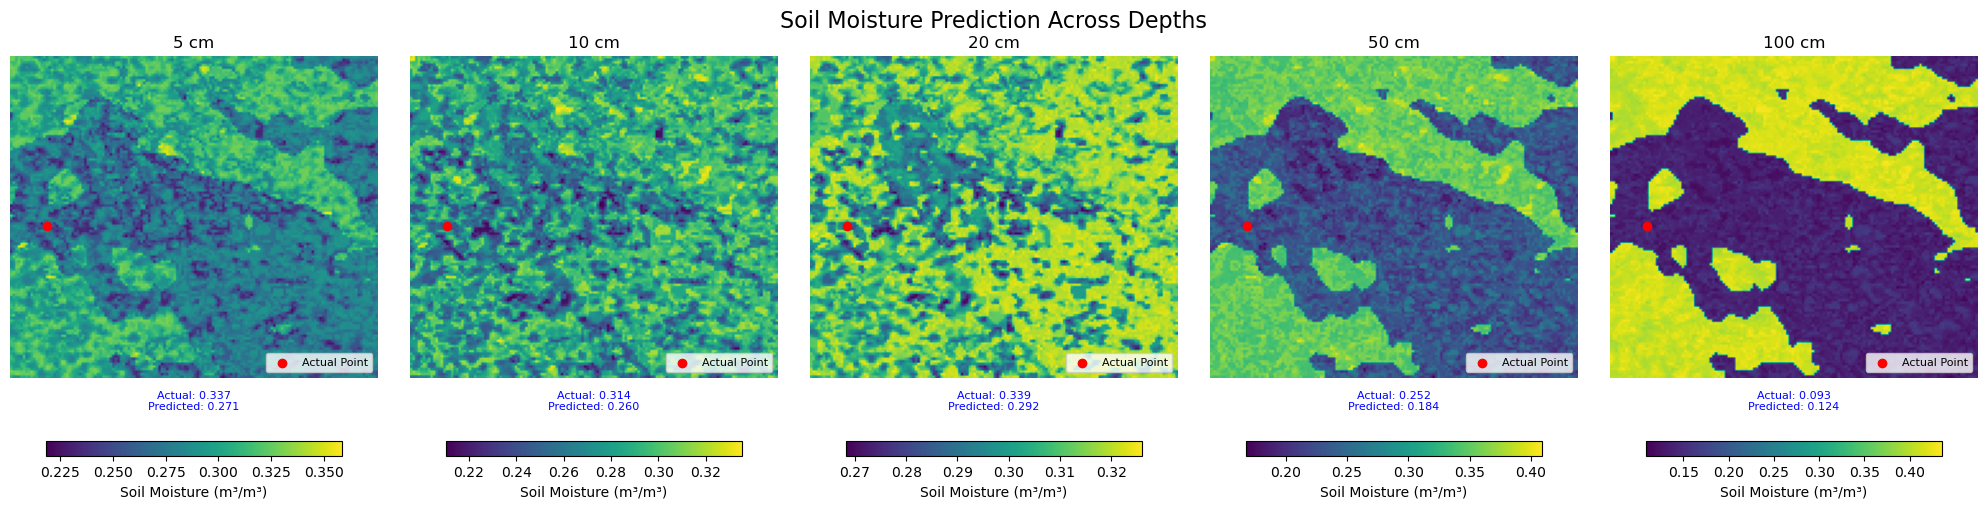

Saved RMSE comparison to insitu_comparison_rmse.csv


In [10]:
# Compare with in-situ data and log metrics
insitu_data = pd.read_csv("Datasets/cleaned_Insitu_SM_2024_ILINKS.csv")
#insitu_data['SOIL_MOISTURE_15_DAILY'] = (insitu_data['SOIL_MOISTURE_10_DAILY'] + insitu_data['SOIL_MOISTURE_20_DAILY']) / 2
#insitu_data['SOIL_MOISTURE_75_DAILY'] = (insitu_data['SOIL_MOISTURE_50_DAILY'] + insitu_data['SOIL_MOISTURE_100_DAILY']) / 2

latitude = 38.09
longitude = -84.75
date = 20240101
point = insitu_data[(insitu_data['LATITUDE'] == latitude) &
                    (insitu_data['LONGITUDE'] == longitude) &
                    (insitu_data['LST_DATE'] == date)]
actual_values = point[['SOIL_MOISTURE_5_DAILY', 'SOIL_MOISTURE_10_DAILY', 'SOIL_MOISTURE_20_DAILY', 'SOIL_MOISTURE_50_DAILY', 'SOIL_MOISTURE_100_DAILY']].values.flatten()

lat_idx = int((latitude - src.bounds.top) / src.res[1])
lon_idx = int((src.bounds.left - longitude) / src.res[0])
predicted_values = predicted_sm[lat_idx, lon_idx, :]

# Initialize rmse_log as an empty list
rmse_log = []

fig, axes = plt.subplots(1, 5, figsize=(20, 5), constrained_layout=True)

for i, ax in enumerate(axes):
    im = ax.imshow(predicted_sm[:, :, i], cmap='viridis')
    ax.set_title(f"{depths[i]}")
    ax.axis('off')
    ax.scatter(lon_idx, lat_idx, color='red', label='Actual Point')
    ax.legend(loc='lower right', fontsize=8)
    ax.text(0.5, -0.1, f"Actual: {actual_values[i]:.3f}\nPredicted: {predicted_values[i]:.3f}",
            transform=ax.transAxes, fontsize=8, ha='center', color='blue')
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', fraction=0.046, pad=0.08)
    cbar.set_label('Soil Moisture (m³/m³)')

plt.suptitle("Soil Moisture Prediction Across Depths", fontsize=16)
plt.savefig("Results/XGboost_Soil_Moisture_Prediction_All_Depths.png", dpi=300)
plt.show()

# Save RMSE log to CSV
rmse_df = pd.DataFrame(rmse_log)
rmse_df.to_csv("insitu_comparison_rmse.csv", index=False)
print("Saved RMSE comparison to insitu_comparison_rmse.csv")

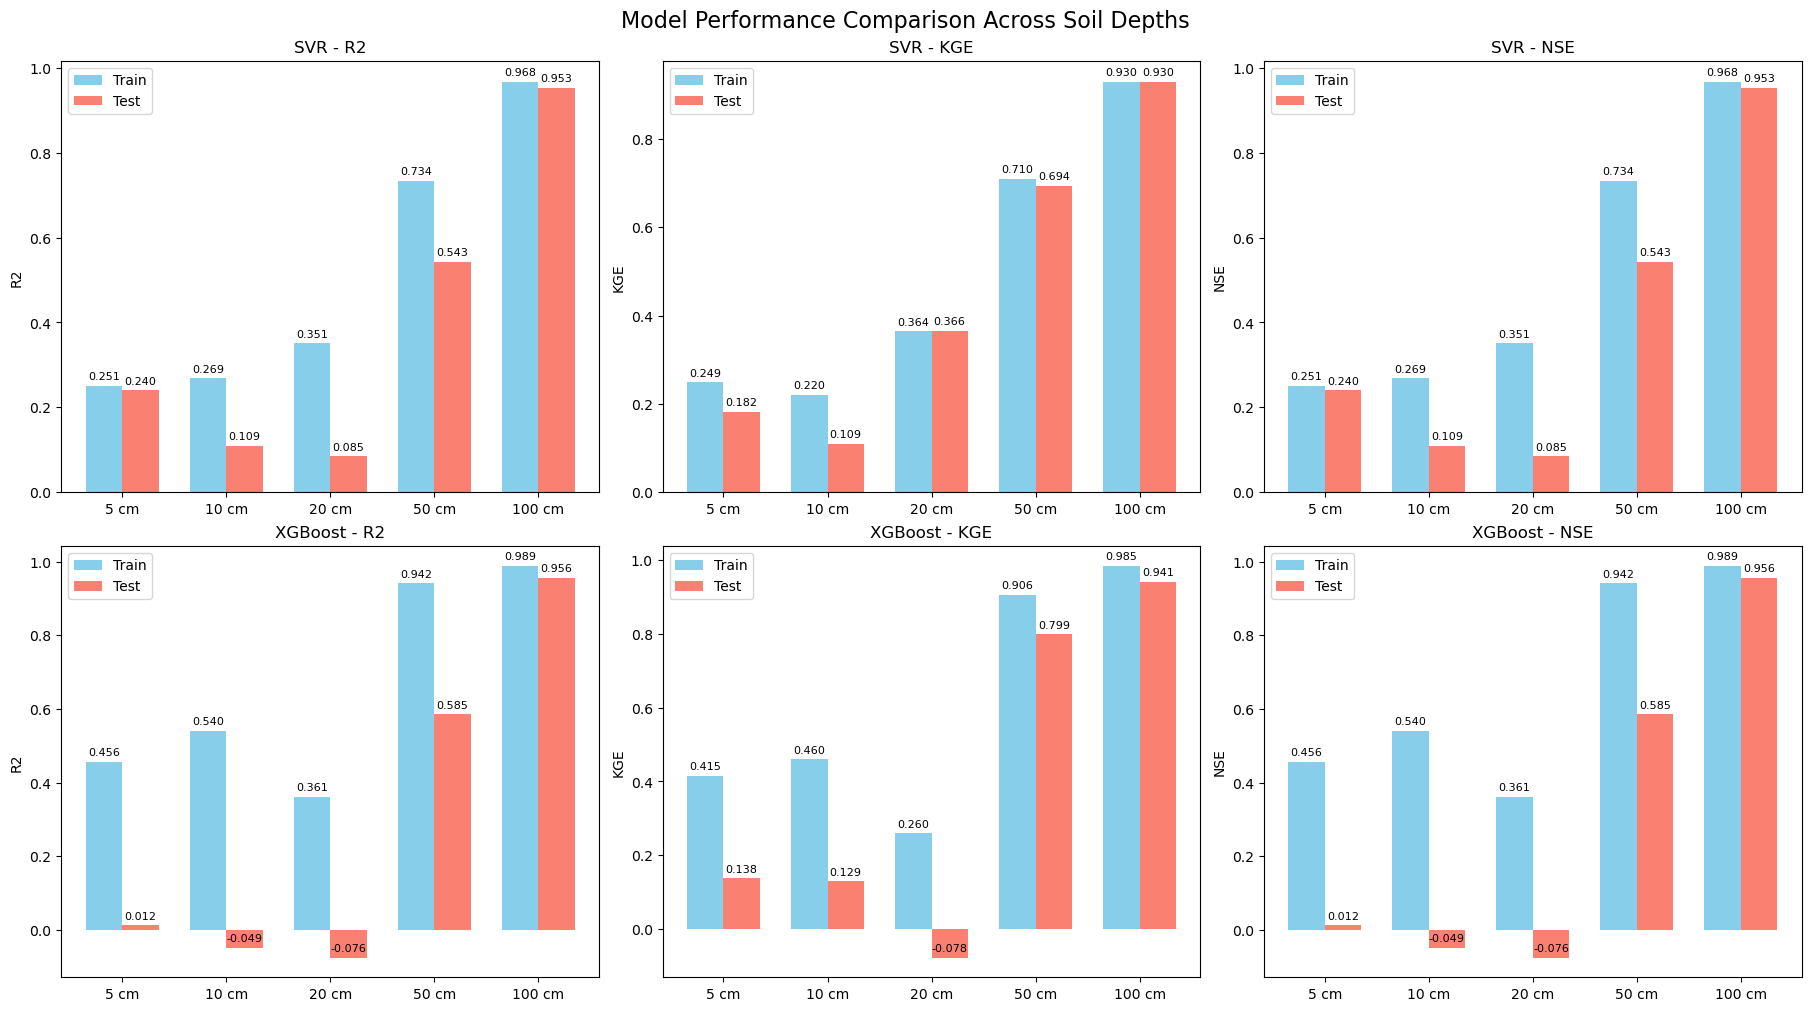

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Define performance results for each model and depth
depths = ['5 cm', '10 cm', '20 cm', '50 cm', '100 cm']

# SVR model results
svr_results = {
    '5 cm': {'R2': {'train': 0.251, 'test': 0.240},
             'KGE': {'train': 0.249, 'test': 0.182},
             'NSE': {'train': 0.251, 'test': 0.240}},
    '10 cm': {'R2': {'train': 0.269, 'test': 0.109},
              'KGE': {'train': 0.220, 'test': 0.109},
              'NSE': {'train': 0.269, 'test': 0.109}},
    '20 cm': {'R2': {'train': 0.351, 'test': 0.085},
              'KGE': {'train': 0.364, 'test': 0.366},
              'NSE': {'train': 0.351, 'test': 0.085}},
    '50 cm': {'R2': {'train': 0.734, 'test': 0.543},
              'KGE': {'train': 0.710, 'test': 0.694},
              'NSE': {'train': 0.734, 'test': 0.543}},
    '100 cm': {'R2': {'train': 0.968, 'test': 0.953},
               'KGE': {'train': 0.930, 'test': 0.930},
               'NSE': {'train': 0.968, 'test': 0.953}},
}

# XGBoost model results
xgb_results = {
    '5 cm': {'R2': {'train': 0.456, 'test': 0.012},
             'KGE': {'train': 0.415, 'test': 0.138},
             'NSE': {'train': 0.456, 'test': 0.012}},
    '10 cm': {'R2': {'train': 0.540, 'test': -0.049},
              'KGE': {'train': 0.460, 'test': 0.129},
              'NSE': {'train': 0.540, 'test': -0.049}},
    '20 cm': {'R2': {'train': 0.361, 'test': -0.076},
              'KGE': {'train': 0.260, 'test': -0.078},
              'NSE': {'train': 0.361, 'test': -0.076}},
    '50 cm': {'R2': {'train': 0.942, 'test': 0.585},
              'KGE': {'train': 0.906, 'test': 0.799},
              'NSE': {'train': 0.942, 'test': 0.585}},
    '100 cm': {'R2': {'train': 0.989, 'test': 0.956},
               'KGE': {'train': 0.985, 'test': 0.941},
               'NSE': {'train': 0.989, 'test': 0.956}},
}

metrics = ['R2', 'KGE', 'NSE']
models = {'SVR': svr_results, 'XGBoost': xgb_results}

# Create a 2x3 grid of subplots (rows: models, cols: metrics)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), constrained_layout=True)

bar_width = 0.35
x = np.arange(len(depths))

for row, (model_name, results) in enumerate(models.items()):
    for col, metric in enumerate(metrics):
        ax = axes[row, col]
        train_vals = [results[d][metric]['train'] for d in depths]
        test_vals = [results[d][metric]['test'] for d in depths]
        
        bars1 = ax.bar(x - bar_width/2, train_vals, bar_width, label='Train', color='skyblue')
        bars2 = ax.bar(x + bar_width/2, test_vals, bar_width, label='Test', color='salmon')
        
        # Annotate bars with metric values
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)
        for bar in bars2:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)
                        
        ax.set_title(f"{model_name} - {metric}")
        ax.set_xticks(x)
        ax.set_xticklabels(depths)
        ax.set_ylabel(metric)
        ax.legend()

fig.suptitle("Model Performance Comparison Across Soil Depths", fontsize=16)
plt.show()